In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('/apps/external_plugins/')
import django
django.setup()
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')


## Gaussian Models for geostatistical data
This notebook generates the figures in Chapter 3 of `Model-Based Geostatistics` (Diggle, Ribeiro, 2007). 
The goal is to provide a Python alternative to the popular R package `geoR`.

In [2]:
from spystats import tools

## Computation

Here we will show how to plot the standard correlation functions. Currently `spystats.tools` have implemented the following models:
    * Matern Model  tools.MaternVariogram()
    * Exponential Model  tools.ExponentialVariogram()
    * Gaussian Model  tools.GaussianVariogram()
    * Spherical Model  tools.SphericalVariogram()
    * Whittle Model  tools.WhittleVariogram()
    
We will plot a function similar to the figure 3.2 (Diggle and Ribeiro,2007)

In [3]:
x = np.linspace(0,1,101)

In [4]:
m1 = tools.MaternVariogram(sill=1,range_a=0.25,kappa=0.5)
m2 = tools.MaternVariogram(sill=1,range_a=0.16,kappa=1.5)
m3 = tools.MaternVariogram(sill=1,range_a=0.13,kappa=2.5)

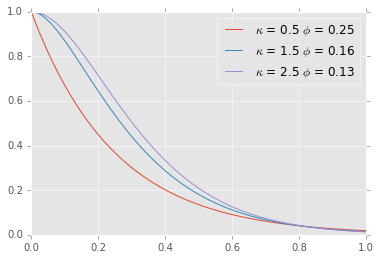

In [5]:
plt.plot(x,m1.corr_f(x))
plt.plot(x,m2.corr_f(x))
plt.plot(x,m3.corr_f(x))
plt.legend(['$\kappa$ = 0.5 $\phi$ = 0.25' ,'$\kappa$ = 1.5 $\phi$ = 0.16','$\kappa$ = 2.5 $\phi$ = 0.13'])

The next example is to demonstrate how to simulate a Gaussian Random Field.

In [6]:
grid = tools.createSquareGrid()
%time s = map(lambda m : tools.simulateGaussianRandomField(m,grid,random_seed=12345),[m1,m2,m3])

CPU times: user 58.8 s, sys: 1.41 s, total: 1min
Wall time: 21.9 s


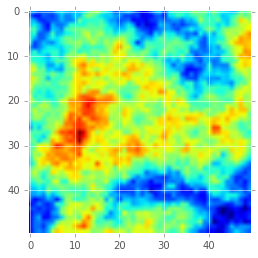

In [7]:
plt.imshow(s[0],interpolation=None)

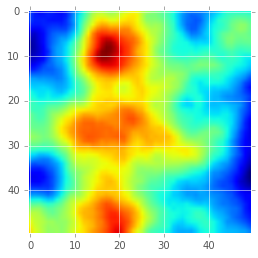

In [8]:
plt.imshow(s[1],interpolation=None)


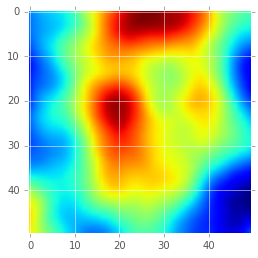

In [9]:
plt.imshow(s[2],interpolation=None)

## Example to use anisotropy.
First thing needed a rotation matrix. Here I'm using the formulas given by Diggle and Ribeiro (2007) in section 3.7.

In [10]:
phi_A = (np.pi / 3.0)
#phi_A = 0.0
phi_R = 4.0
a = np.array([[np.cos(phi_A), -np.sin(phi_A)],[np.sin(phi_A),np.cos(phi_A)]])
b = np.array([[1, 0],[0,1.0 / phi_R]])

In [11]:
A = np.matmul(a,b)

In [12]:
new_coords = np.dot(grid[['Lon','Lat']].values,A)
n = len(new_coords)
nc = pd.DataFrame({'nLon':new_coords[:,0],'nLat':new_coords[:,1],'Y': np.zeros(n)})
nc = tools.toGeoDataFrame(nc,'nLon','nLat')

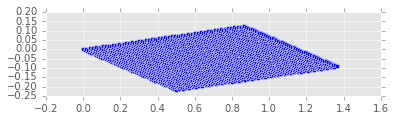

In [13]:
nc.plot()

In [14]:
vg = tools.Variogram(nc,'Y',model=m2)

In [15]:
Sigma = vg.calculateCovarianceMatrix()

In [16]:
from scipy.stats import multivariate_normal as mvn
sim1 = mvn.rvs(mean=nc.Y,cov=Sigma)   
n_2 = int(np.sqrt(n))

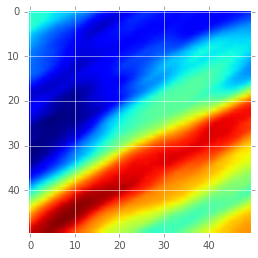

In [17]:
plt.imshow(sim1.reshape(n_2,n_2))

## Now let's do this with affine transformations.
We expect to see the same results. If we use the same parameters. 
Remember that the space of affine transformations is isomorphic to the projection space (except for a point at infinity, I know)

### Remember that the Grid object is a Geodataframe object
Therefore, it has the functions of Geometric Manipulations. (See: http://geopandas.org/geometric_manipulations.html?highlight=affine)

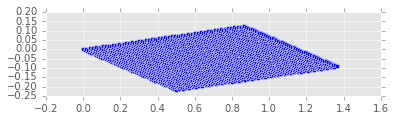

In [18]:
transgrid = grid.geometry.rotate(-phi_A, origin=(0,0),use_radians=True).scale(1,1.0 / phi_R,origin=(0,0))
transgrid.plot()

If you go back (up) to the manually transformed coordinates you will find out that the plot is the same. Except for the argument phi_R that, for the geodataframe object/method (shapely) it should be -phi_R. 
Remmember also to use origin=(something). Without this the method will not work.

In [19]:
grid['transcoords'] = transgrid
grid = grid.set_geometry('transcoords')

In [20]:
grid = grid.set_geometry('transcoords')

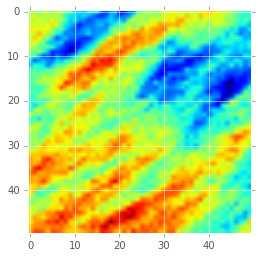

In [21]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m1,random_seed=12345)
plt.imshow(transfield)

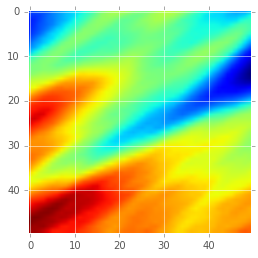

In [22]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m2,random_seed=12345)
plt.imshow(transfield)

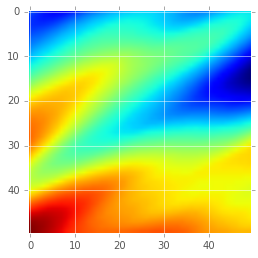

In [23]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m3,random_seed=12345)
plt.imshow(transfield)

Lastly lets do a perspective gaussian process

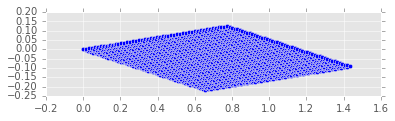

In [24]:

#grid = grid.set_geometry('geometry')
p = np.pi / 5.0
transgrid = grid.geometry.skew(-p,origin=(0,0),use_radians=True)
transgrid.plot()

In [25]:
grid['transcoords'] = transgrid
grid = grid.set_geometry('transcoords')

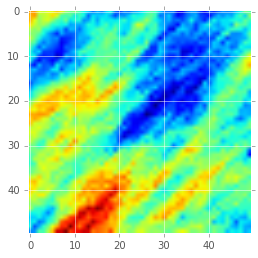

In [26]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m1,random_seed=12345)
plt.imshow(transfield)

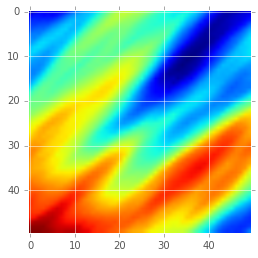

In [27]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m2,random_seed=12345)
plt.imshow(transfield)

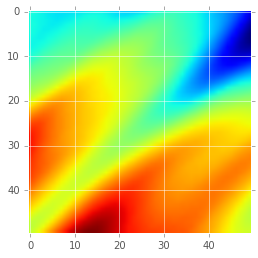

In [28]:
transfield= tools.simulateGaussianRandomField(grid=grid,variogram_model=m3,random_seed=12345)
plt.imshow(transfield)